In [3]:
%pip install pennylane

  Using cached PennyLane-0.41.1-py3-none-any.whl.metadata (10 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached autoray-0.7.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pennylane_lightning-0.41.1-cp311-cp311-macosx_13_0_arm64.whl.metadata (12 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached diastatic_malt-2.15.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached scipy_openblas32-0.3.29.0.0-py3-none-macosx_11_0_arm64.whl.metadata (56 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached charset

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Function

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

import pennylane as qml

## Data Preparation

In [10]:
%pip install -U scikit-learn

  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.5.0-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
train_dataset = pd.read_csv("/Users/soardr/FLIQ/Datasets/drug+induced+autoimmunity+prediction/DIA_trainingset_RDKit_descriptors.csv")
test_dataset = pd.read_csv("/Users/soardr/FLIQ/Datasets/drug+induced+autoimmunity+prediction/DIA_testset_RDKit_descriptors.csv")

In [5]:
X = train_dataset.drop(['Label', 'SMILES'], axis=1)
y = train_dataset['Label']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                test_size=0.2, 
                                                shuffle=True, 
                                                stratify=y, 
                                                random_state=42)

In [7]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((381, 196), (96, 196), (381,), (96,))

## Model definition

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

device = torch.device(device)
print(device)

mps


In [9]:
class FullClassical(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullClassical, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)

        return self.softmax(x)

In [10]:
model_FullClassical = FullClassical(X_train.shape[1], 2).to(device)

## Loss function and Optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_FullClassical.parameters(), lr=0.001)

## Training and Validation Loaders

In [12]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

In [14]:
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

## Training

In [15]:
num_epochs = 20

In [16]:
for epoch in range(num_epochs):
    model_FullClassical.train()
    running_loss = 0.0

    for batch in training_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_FullClassical(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(training_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/20], Loss: 0.5872
Epoch [2/20], Loss: 0.5594
Epoch [3/20], Loss: 0.5611
Epoch [4/20], Loss: 0.5599
Epoch [5/20], Loss: 0.5605
Epoch [6/20], Loss: 0.5593
Epoch [7/20], Loss: 0.5593
Epoch [8/20], Loss: 0.5599
Epoch [9/20], Loss: 0.5587
Epoch [10/20], Loss: 0.5611
Epoch [11/20], Loss: 0.5611
Epoch [12/20], Loss: 0.5586
Epoch [13/20], Loss: 0.5610
Epoch [14/20], Loss: 0.5592
Epoch [15/20], Loss: 0.5604
Epoch [16/20], Loss: 0.5604
Epoch [17/20], Loss: 0.5608
Epoch [18/20], Loss: 0.5617
Epoch [19/20], Loss: 0.5604
Epoch [20/20], Loss: 0.5603


In [17]:
model_FullClassical.eval()
val_loss = 0.0
correct = 0

all_pred = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_FullClassical(inputs)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        all_pred.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = correct / len(val_dataset)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.5632, Validation Accuracy: 0.7500


## Classification report

In [18]:
print("Classification Report:")
print(classification_report(all_labels, all_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571        72
           1     0.0000    0.0000    0.0000        24

    accuracy                         0.7500        96
   macro avg     0.3750    0.5000    0.4286        96
weighted avg     0.5625    0.7500    0.6429        96



/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
acc = accuracy_score(all_labels, all_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7500


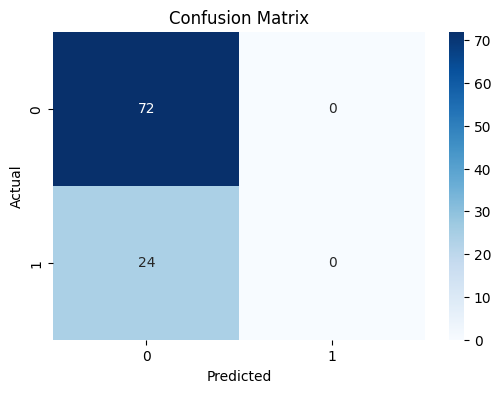

In [20]:
cm = confusion_matrix(all_labels, all_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Saving model

In [21]:
torch.save(model_FullClassical, "/Users/soardr/FLIQ/models for DIA/model_FullClassical.pth")

## Loading model

In [22]:
loaded__model_FullClassical = torch.load("/Users/soardr/FLIQ/models for DIA/model_FullClassical.pth", weights_only=False)
loaded__model_FullClassical.eval()

FullClassical(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

# Testing model on test dataset

In [23]:
X_test = test_dataset.drop(['Label', 'SMILES'], axis=1)
y_test = test_dataset['Label']

In [24]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [25]:
test_preds_model = np.argmax(model_FullClassical(X_test_tensor.to(device)).cpu().detach().numpy(), axis=1)

In [26]:
print("Prediction Classification Report:")
print(classification_report(y_test_tensor, test_preds_model, digits=4))

Prediction Classification Report:
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571        90
           1     0.0000    0.0000    0.0000        30

    accuracy                         0.7500       120
   macro avg     0.3750    0.5000    0.4286       120
weighted avg     0.5625    0.7500    0.6429       120



/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/soardr/FLIQ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
acc = accuracy_score(y_test_tensor, test_preds_model)
print(f"Prediction Accuracy: {acc:.4f}")

Prediction Accuracy: 0.7500


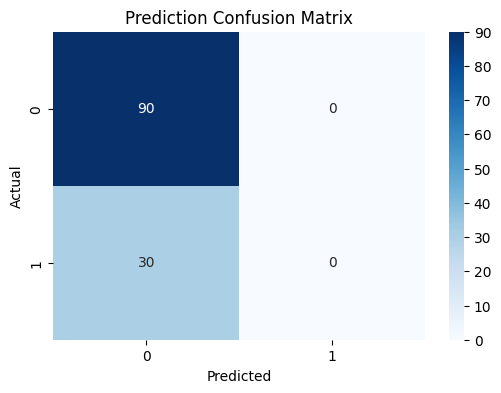

In [28]:
cm = confusion_matrix(y_test_tensor, test_preds_model)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()